In [3]:
import cv2

from skimage import io


import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt
import re

import os
from tqdm import tqdm
import csv


from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [68]:
class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=5):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self, if_return_color_weights=False):
        '''Эта функция выдает параметры R, G, B для самых превалирующих на картинке цветов'''
    
        #read image
        
        img = cv2.imread(self.IMAGE)
        #convert to rgb from bgr
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(img)
        
        #the cluster centers are our dominant colors.
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        #returning after converting to integer from float
        if if_return_color_weights:
            numLabels = np.arange(0, self.CLUSTERS+1)
            (hist, _) = np.histogram(self.LABELS, bins = numLabels)
            hist = hist.astype("float")
            hist /= hist.sum()
            return self.COLORS.astype(int), hist
        else:
            return self.COLORS.astype(int)

    
    def plotHistogram(self): 
        '''Эта функция строит гистограмму с превалирующими цветами в картинке, и это гораздо быстрее, чем 
        раскрашивать месиво'''
        
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()
        

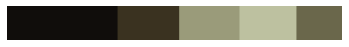

In [71]:
img = '/Users/tonleon/Documents/GitHub/Diploma/Films/2012_frames/138_frame.jpg'
clusters = 5
dc1 = DominantColors(img, clusters)
colors1, hist1 = dc1.dominantColors(if_return_color_weights=True)
dc1.plotHistogram()

In [29]:
colors1.T @ hist1

array([68.70027657, 87.83502557, 89.4735206 ])

In [72]:
os.listdir('/Users/tonleon/Documents/GitHub/Diploma/Films/2012_frames')

['2609_frame.jpg',
 '2323_frame.jpg',
 '5735_frame.jpg',
 '7730_frame.jpg',
 '5029_frame.jpg',
 '5503_frame.jpg',
 '2115_frame.jpg',
 '97_frame.jpg',
 '5818_frame.jpg',
 '7506_frame.jpg',
 '2924_frame.jpg',
 '7676_frame.jpg',
 '7395_frame.jpg',
 '5359_frame.jpg',
 '5390_frame.jpg',
 '5673_frame.jpg',
 '2786_frame.jpg',
 '2265_frame.jpg',
 '2862_frame.jpg',
 '7489_frame.jpg',
 '7440_frame.jpg',
 '5997_frame.jpg',
 '2579_frame.jpg',
 '2053_frame.jpg',
 '5445_frame.jpg',
 '379_frame.jpg',
 '6446_frame.jpg',
 '653_frame.jpg',
 '3864_frame.jpg',
 '4991_frame.jpg',
 '1099_frame.jpg',
 '4958_frame.jpg',
 '1050_frame.jpg',
 '3055_frame.jpg',
 '6994_frame.jpg',
 '1861_frame.jpg',
 '4169_frame.jpg',
 '4443_frame.jpg',
 '1785_frame.jpg',
 '1266_frame.jpg',
 '186_frame.jpg',
 '465_frame.jpg',
 '6393_frame.jpg',
 '6670_frame.jpg',
 '4675_frame.jpg',
 '4396_frame.jpg',
 '3749_frame.jpg',
 '3263_frame.jpg',
 '3780_frame.jpg',
 '4505_frame.jpg',
 '1927_frame.jpg',
 '3439_frame.jpg',
 '3113_frame.jpg',

In [100]:
path_2012 = '/Users/tonleon/Documents/GitHub/Diploma/Films/trial_frames_2012'
path_1967 = '/Users/tonleon/Documents/GitHub/Diploma/Films/trial_frames_1967'
path_1997 = '/Users/tonleon/Documents/GitHub/Diploma/Films/trial_frames_1997'

In [78]:
def make_weighted_color_image_description_array(path, clusters=5):
    data = []
    src = []
    for file in tqdm(os.listdir(path)):
        if file.endswith('.jpg'):
            src.append(os.path.join(path, file))
            dc = DominantColors(os.path.join(path, file), clusters)
            colors, weights = dc.dominantColors(if_return_color_weights=True)
            data.append(colors.T @ weights)
    return np.vstack(data), src

In [79]:
data_array_2012, src_2012 = make_weighted_color_image_description_array(path_2012)
data_array_1967, src_1967 = make_weighted_color_image_description_array(path_1967)

100%|██████████| 121/121 [07:56<00:00,  3.94s/it]


In [101]:
data_array_1997, src_1997 = make_weighted_color_image_description_array(path_1997)

100%|██████████| 121/121 [16:55<00:00,  8.39s/it]


In [109]:
savetxt('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/2012/trial_dominant_colors_2012.csv', data_array_2012, fmt='%.f', delimiter=',')
savetxt('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/1997/trial_dominant_colors_1997.csv', data_array_1997, fmt='%.f', delimiter=',')
savetxt('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/1967/trial_dominant_colors_1967.csv', data_array_1967, fmt='%.f', delimiter=',')

# Последующая обработка 

### 1 Вариант

In [1]:
def src_path(path):
    src = []
    for file in tqdm(os.listdir(path)):
            if file.endswith('.jpg'):
                src.append(os.path.join(path, file))
    return src

In [4]:
src_1967 = src_path('/Users/tonleon/Documents/GitHub/Diploma/Films/1967_frames')
src_1997 = src_path('/Users/tonleon/Documents/GitHub/Diploma/Films/1997_frames')

100%|██████████| 6468/6468 [00:00<00:00, 339967.90it/s]


In [7]:
import re
# relative_source_2012 = [re.findall('trial_frames_2012.+', line)[0] for line in src_2012]
relative_source_1967 = [re.findall('1967_frames.+', line)[0] for line in src_1967]
relative_source_1997 = [re.findall('1997_frames.+', line)[0] for line in src_1997]

### 2 Вариант

In [20]:
with open("/Users/tonleon/Documents/GitHub/Diploma/Films/Data/1967/src_1967.txt", "r") as f:
    src_1967 = f.readlines() 
    f.close()
        
with open("/Users/tonleon/Documents/GitHub/Diploma/Films/Data/1997/src_1997.txt", "r") as f:
    src_1997 = f.readlines() 
    f.close()

In [21]:
relative_source_1967 = [re.sub('./|\\n', '', line) for line in src_1967]
relative_source_1967 = [re.sub('\\\\', '/', line) for line in relative_source_1967]
relative_source_1997 = [re.sub('./|\\n', '', line) for line in src_1997]
relative_source_1997 = [re.sub('\\\\', '/', line) for line in relative_source_1997]

In [22]:
with open('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/1967/dominant_colors_1967.csv', newline='') as csvfile:
    data_array_1967 = np.array(list(csv.reader(csvfile)))
with open('/Users/tonleon/Documents/GitHub/Diploma/Films/Data/1997/dominant_colors_1997.csv', newline='') as csvfile:
    data_array_1997 = np.array(list(csv.reader(csvfile)))   

In [76]:
# pca_mean_colors_2012 = PCA(2).fit_transform(data_array_2012)
pca_mean_colors_1967 = PCA(2).fit_transform(data_array_1967)
pca_mean_colors_1997 = PCA(2).fit_transform(data_array_1997)

In [77]:
pca_mean_colors_1997[:, 1] = - pca_mean_colors_1997[:, 1] 
#чтобы по игреку цвет менялся от синего к красному а не наоборот

In [78]:
'''Код визуализации, на которой можно отобразить изображения при наведении мышки на точку.'''
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
from bokeh.plotting import ColumnDataSource, figure, output_file, show
output_notebook()

# output_file("toolbar.html")

Loading BokehJS ...

In [82]:
def visualize_color_distribution(pca_mean_colors_film_list, relative_sources_list, each_n_frame=5,
                                       colors=['#ff0000', 
                                               '#0000ff',
                                               'royalblue',
                                               'black',
                                               'pink',
                                               'sandybrown']):
    
    sources = [
        ColumnDataSource(data=dict(
            x= pca_mean_colors[:,0][::each_n_frame],
            y= pca_mean_colors[:, 1][::each_n_frame],
            desc=list(range(len(relative_source)))[::each_n_frame],
            imgs= relative_source[::each_n_frame],
            fonts = ['<i>trailer</i>'] * len(relative_source[::each_n_frame]))
        )
        for pca_mean_colors, relative_source in zip(pca_mean_colors_film_list, relative_sources_list)]



    TOOLTIPS = """
        <div>
            <div>
                <img
                    src="@imgs" height="187" alt="@imgs" width=333""
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 15px; color: #966; alpha: 0.25">[$index]</span>
            </div>
            <div>
                <span>@fonts{safe}</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;  alpha: 0.25">($x, $y)</span>
            </div>
        </div>
    """

    p = figure(plot_width=1000, plot_height=500, tooltips=TOOLTIPS,
               title="Color Distribution in Film Adaptations of Anna Karenina")

    # p.circle('x', 'y', size=15, alpha=0.25, color='#62b696', source=source_2012)
    for source, color in zip(sources, colors):
        p.circle('x', 'y', size=15, alpha=0.25, color=color, source=source)

    show(p)

In [81]:
visualize_color_distribution([pca_mean_colors_1967, pca_mean_colors_1997], 
                             [relative_source_1967, relative_source_1997])